In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image


In [3]:
from Pruning.laprune import LAP 

In [5]:
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))]) # tanh
# transform = transforms.ToTensor()
# mnist_data = datasets.MNIST(root = '/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GAN_PROJ',train=True,download=True,transform=transform)
# data_loader = torch.utils.data.DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)


In [6]:
# mnist_data_fashion = datasets.FashionMNIST(root = '/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GAN_PROJ',train=True,download=True,transform=transform)
# data_loader_fashion = torch.utils.data.DataLoader(dataset=mnist_data_fashion,batch_size=64,shuffle=True)

In [4]:
data = pd.read_csv('/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GNNProject/DataPreparation/CorruptedData/Names.csv')


In [5]:
class FashionMNISTDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,image

In [6]:
transform = transforms.ToTensor()

In [7]:
root_dir = '/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GNNProject/DataPreparation/CorruptedData'
dataset = FashionMNISTDataset(dataframe=data,root_dir=root_dir,transform=transform)


In [8]:
total_images = len(dataset)
print(f'Total number of images: {total_images}')

Total number of images: 60000


In [57]:
subset_size = int(0.3 * total_images)  
indices = torch.randperm(len(dataset)).tolist()
subset_indices = indices[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

In [58]:
# Split the subset dataset into train and test sets
train_size = int(0.8 * len(subset_dataset))  # 80% for training
test_size = len(subset_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [59]:
images,_ = next(iter(train_dataloader))
print(images.shape)

torch.Size([64, 1, 28, 28])


In [60]:
dataiter= iter(train_dataloader)
images,labels = dataiter.__next__()
print(torch.min(images),torch.max(images))

tensor(0.) tensor(0.9451)


In [61]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_sizes, layers):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_sizes = hidden_sizes
        self.layers = layers

        # Encoder
        encoder_layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, layers):
            encoder_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(hidden_sizes[-1], bottleneck_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = [nn.Linear(bottleneck_size, hidden_sizes[-1]), nn.ReLU()]
        for i in reversed(range(1, layers)):
            decoder_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_sizes[0], input_size))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def calculate_loss(self, X):
        reconstructed = self.forward(X)
        loss = nn.MSELoss()(reconstructed, X)
        return loss

    def train_autoencoder(self, dataloader, epochs, lr=0.01, use_lap=False, prune_ratios=None, bn_factors=None, lap_interval=5):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        losses = []
        sparsity_levels = []

        for epoch in range(epochs):
            total_loss = 0
            for X_batch, _ in dataloader:
                X_batch = X_batch.float()
                X_batch = X_batch.view(X_batch.size(0), -1)

                optimizer.zero_grad()
                loss = self.calculate_loss(X_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            sparsity_levels.append(self.calculate_sparsity())  # Store sparsity level

            if use_lap and epoch % lap_interval == 0 and epoch > 0:
                self.apply_lap(prune_ratios, bn_factors)

            print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Sparsity Level: {sparsity_levels[-1]}')

        return losses, sparsity_levels
    def calculate_sparsity(self):
        total_weights = 0
        total_zero_weights = 0
        for param in self.parameters():
            if param.dim() > 1:  # Only consider weights of layers, not biases
                total_weights += param.numel()
                total_zero_weights += torch.sum(param == 0).item()
        sparsity_level = total_zero_weights / total_weights
        return sparsity_level


    def apply_lap(self, prune_ratios, bn_factors=None):
        weights = [param.data for param in self.parameters() if len(param.data.size()) > 1]
        masks = [torch.ones_like(weight) for weight in weights]
        
        # Assuming LAP function is correctly implemented and available
        new_masks = LAP(weights, masks, prune_ratios, bn_factors=bn_factors)
        
        # Apply new masks
        for param, mask in zip([param for param in self.parameters() if len(param.data.size()) > 1], new_masks):
            param.data.mul_(mask)

In [62]:
input_size = 784  # For MNIST
bottleneck_size = 32
hidden_sizes = [128, 64]
layers = 2
epochs = 100
lr = 0.01
autoencoder = AutoEncoder(input_size, bottleneck_size, hidden_sizes, layers)

In [63]:
losses_without_lap, sparsity_levels_without_lap = autoencoder.train_autoencoder(train_dataloader, epochs, lr, use_lap=False)


Epoch 1/100, Average Loss: 0.016455236362914245, Sparsity Level: 0.0
Epoch 2/100, Average Loss: 0.006639135159138177, Sparsity Level: 0.0
Epoch 3/100, Average Loss: 0.00708829894868864, Sparsity Level: 0.0
Epoch 4/100, Average Loss: 0.006629386403494411, Sparsity Level: 0.0
Epoch 5/100, Average Loss: 0.006642299118555254, Sparsity Level: 0.0
Epoch 6/100, Average Loss: 0.006698141464342674, Sparsity Level: 0.0
Epoch 7/100, Average Loss: 0.006778297093179491, Sparsity Level: 0.0
Epoch 8/100, Average Loss: 0.0067279598654972185, Sparsity Level: 0.0
Epoch 9/100, Average Loss: 0.006734226577811771, Sparsity Level: 0.0
Epoch 10/100, Average Loss: 0.0065986326523125175, Sparsity Level: 0.0
Epoch 11/100, Average Loss: 0.006698911390784714, Sparsity Level: 0.0
Epoch 12/100, Average Loss: 0.006644827247493797, Sparsity Level: 0.0
Epoch 13/100, Average Loss: 0.006657963587592046, Sparsity Level: 0.0
Epoch 14/100, Average Loss: 0.006707556998978058, Sparsity Level: 0.0
Epoch 15/100, Average Loss: 

In [64]:
prune_ratios = [0.1, 0.1, 0.1]  # Adjust based on your network architecture
autoencoder_with_lap = AutoEncoder(input_size, bottleneck_size, hidden_sizes, layers)  # Create another instance for LAP

losses_with_lap, sparsity_levels_with_lap = autoencoder_with_lap.train_autoencoder(train_dataloader, epochs, lr, use_lap=True, prune_ratios=prune_ratios, lap_interval=10)

Epoch 1/100, Average Loss: 0.014085694207913346, Sparsity Level: 0.0
Epoch 2/100, Average Loss: 0.006718455234335528, Sparsity Level: 0.0
Epoch 3/100, Average Loss: 0.006620598743773169, Sparsity Level: 0.0
Epoch 4/100, Average Loss: 0.006633691402773062, Sparsity Level: 0.0
Epoch 5/100, Average Loss: 0.0068133445808457, Sparsity Level: 0.0
Epoch 6/100, Average Loss: 0.00661541905047165, Sparsity Level: 0.0
Epoch 7/100, Average Loss: 0.0066194964469307, Sparsity Level: 0.0
Epoch 8/100, Average Loss: 0.0067462307256129055, Sparsity Level: 0.0
Epoch 9/100, Average Loss: 0.006658261068579223, Sparsity Level: 0.0
Epoch 10/100, Average Loss: 0.006639847084879875, Sparsity Level: 0.0
Epoch 11/100, Average Loss: 0.0069885911047458645, Sparsity Level: 0.0
Epoch 12/100, Average Loss: 0.00746335520926449, Sparsity Level: 0.04427535445601852
Epoch 13/100, Average Loss: 0.0066121128077308335, Sparsity Level: 0.04427535445601852
Epoch 14/100, Average Loss: 0.006584842945966456, Sparsity Level: 0.04

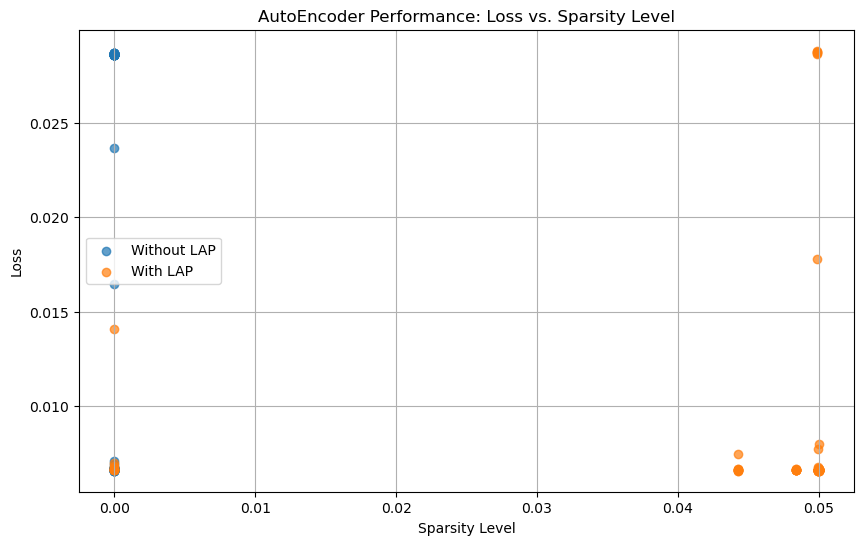

In [65]:
plt.figure(figsize=(10, 6))

# Plot for training without LAP
plt.scatter(sparsity_levels_without_lap, losses_without_lap, label='Without LAP', alpha=0.7)

# Plot for training with LAP
plt.scatter(sparsity_levels_with_lap, losses_with_lap, label='With LAP', alpha=0.7)

plt.title('AutoEncoder Performance: Loss vs. Sparsity Level')
plt.xlabel('Sparsity Level')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.2*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset = random_split(dataset,[train_size,validation_size,test_size])
print(train_size)
print(validation_size)

train_dataset, test_dataset = random_split(dataset, [train_size, validation_size])

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
12000


In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_sizes, layers):
        super().__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_sizes = hidden_sizes
        self.layers = layers
        self.hidden_layers_encoder = []
        self.hidden_layers_decoder = []

        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.output_layer = nn.Linear(hidden_sizes[0], input_size)
        self.bottleneck_layer = nn.Linear(hidden_sizes[-1], bottleneck_size)

        self.hidden_layers_decoder.append(nn.Linear(bottleneck_size,hidden_sizes[-1]))
        self.hidden_layers_decoder.append(nn.ReLU())
        for i in range(1, layers):
            self.hidden_layers_encoder.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.hidden_layers_encoder.append(nn.ReLU())
        for i in reversed(range(1, layers)):
            self.hidden_layers_decoder.append(nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
            self.hidden_layers_decoder.append(nn.ReLU())

        #self.hidden_layers_encoder.append(nn.Linear(hidden_size, bottleneck_size))

        self.encoder = nn.Sequential(self.input_layer,
                                     nn.ReLU(),
                                     *self.hidden_layers_encoder,
                                     self.bottleneck_layer)

        self.decoder = nn.Sequential(
                                    *self.hidden_layers_decoder,
                                     self.output_layer)

        self.model = nn.Sequential(self.encoder, self.decoder)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

    def calculate_loss(self, X):
        error_type = nn.MSELoss()
        reconstructed = self.forward(X)
        loss = error_type(reconstructed, X)
        return loss

    def train_autoencoder(self, train_loader, val_loader, epochs, lr=0.01):
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            criterion = nn.MSELoss()
            train_losses = []
            val_losses = []

            for epoch in range(epochs):
                self.train()  # Set model to training mode
                total_train_loss = 0
                for X_batch, _ in train_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    optimizer.zero_grad()
                    outputs = self(X_batch)
                    train_loss = criterion(outputs, X_batch)
                    train_loss.backward()
                    optimizer.step()
                    total_train_loss += train_loss.item()
                avg_train_loss = total_train_loss / len(train_loader)
                train_losses.append(avg_train_loss)

                # Validation
                self.eval()  # Set model to evaluation mode
                total_val_loss = 0
                with torch.no_grad():
                    for X_batch, _ in val_loader:
                        X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                        outputs = self(X_batch)
                        val_loss = criterion(outputs, X_batch)
                        total_val_loss += val_loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

                print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            return train_losses, val_losses
                    

In [24]:
# Assuming necessary imports and DataLoader setup as before

# Hyperparameters
hidden_sizes_options = [[128], [256, 128], [512, 256, 128]]
learning_rate_options = [0.01, 0.001]
epochs_options = [5, 10]
bottleneck_sizes = [64, 32]

best_val_loss = float('inf')
best_params = {}

for hidden_sizes in hidden_sizes_options:
    for lr in learning_rate_options:
        for epochs in epochs_options:
            for bottleneck_size in bottleneck_sizes:
                # Calculate 'layers' based on the length of hidden_sizes
                layers = len(hidden_sizes)
                
                # Adjusted model instantiation to include 'layers'
                model = AutoEncoder(input_size=784, bottleneck_size=bottleneck_size, hidden_sizes=hidden_sizes, layers=layers)
                print(f'Training with hidden_sizes={hidden_sizes}, lr={lr}, epochs={epochs}, bottleneck_size={bottleneck_size}, layers={layers}')
                
                # Updated to capture the return value correctly
                train_losses, val_losses = model.train_autoencoder(train_dataloader, validation_dataloader, epochs, lr)
                
                # Assuming you want to consider the last validation loss for comparison
                last_val_loss = val_losses[-1]
                if last_val_loss < best_val_loss:
                    best_val_loss = last_val_loss
                    best_params = {
                        'hidden_sizes': hidden_sizes,
                        'learning_rate': lr,
                        'epochs': epochs,
                        'bottleneck_size': bottleneck_size,
                        'layers': layers  # Keep track of the 'layers' in best parameters
                    }

print(f'Best Parameters: {best_params}')


Training with hidden_sizes=[128], lr=0.01, epochs=5, bottleneck_size=64, layers=1
Epoch 1, Train Loss: 0.0085, Val Loss: 0.0067
Epoch 2, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 3, Train Loss: 0.0068, Val Loss: 0.0066
Epoch 4, Train Loss: 0.0066, Val Loss: 0.0066
Epoch 5, Train Loss: 0.0066, Val Loss: 0.0066
Training with hidden_sizes=[128], lr=0.01, epochs=5, bottleneck_size=32, layers=1
Epoch 1, Train Loss: 0.0082, Val Loss: 0.0067
Epoch 2, Train Loss: 0.0067, Val Loss: 0.0066
Epoch 3, Train Loss: 0.0067, Val Loss: 0.0066
Epoch 4, Train Loss: 0.0184, Val Loss: 0.0288
Epoch 5, Train Loss: 0.0285, Val Loss: 0.0287
Training with hidden_sizes=[128], lr=0.01, epochs=10, bottleneck_size=64, layers=1
Epoch 1, Train Loss: 0.0072, Val Loss: 0.0042
Epoch 2, Train Loss: 0.0219, Val Loss: 0.0287
Epoch 3, Train Loss: 0.0287, Val Loss: 0.0288
Epoch 4, Train Loss: 0.0286, Val Loss: 0.0287
Epoch 5, Train Loss: 0.0285, Val Loss: 0.0288
Epoch 6, Train Loss: 0.0285, Val Loss: 0.0287
Epoch 7, Train Lo

In [17]:
#Test 01
best_params = {'hidden_sizes': [128], 'learning_rate': 0.001, 'epochs': 10, 'bottleneck_size': 64, 'layers': 1}
# Instantiate with these parameters
model = AutoEncoder(input_size=784,bottleneck_size=best_params['bottleneck_size'],hidden_sizes=best_params['hidden_sizes'],layers=best_params['layers'])

In [27]:
train_losses,val_losses = model.train_autoencoder(train_loader=train_dataloader,val_loader=validation_dataloader,epochs=best_params['epochs'],lr=best_params['learning_rate'])

Epoch 1, Train Loss: 0.0066, Val Loss: 0.0026
Epoch 2, Train Loss: 0.0022, Val Loss: 0.0020
Epoch 3, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0014, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 8, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 9, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 10, Train Loss: 0.0012, Val Loss: 0.0012


In [31]:
#Test 02
model = AutoEncoder(input_size=784,bottleneck_size=32,hidden_sizes=[256, 128],layers=2)
train_losses,val_losses = model.train_autoencoder(train_loader=train_dataloader,val_loader=validation_dataloader,epochs=best_params['epochs'],lr=0.01)

Epoch 1, Train Loss: 0.0136, Val Loss: 0.0289
Epoch 2, Train Loss: 0.0286, Val Loss: 0.0288
Epoch 3, Train Loss: 0.0285, Val Loss: 0.0288
Epoch 4, Train Loss: 0.0285, Val Loss: 0.0290
Epoch 5, Train Loss: 0.0285, Val Loss: 0.0291
Epoch 6, Train Loss: 0.0285, Val Loss: 0.0288
Epoch 7, Train Loss: 0.0285, Val Loss: 0.0288
Epoch 8, Train Loss: 0.0285, Val Loss: 0.0288
Epoch 9, Train Loss: 0.0285, Val Loss: 0.0288
Epoch 10, Train Loss: 0.0285, Val Loss: 0.0287


In [11]:
#Test 03
model = AutoEncoder(input_size=784,bottleneck_size=25,hidden_sizes=[40],layers=1)
train_losses,val_losses = model.train_autoencoder(train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.001)

Epoch 1, Train Loss: 0.0114, Val Loss: 0.0034
Epoch 2, Train Loss: 0.0030, Val Loss: 0.0029
Epoch 3, Train Loss: 0.0028, Val Loss: 0.0027
Epoch 4, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 5, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 6, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 7, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 8, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 9, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 10, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 11, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 12, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 13, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 14, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 15, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 16, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 17, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 18, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 19, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 20, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 21, Train Loss: 0.0026, Val Loss: 0.0026
Epoch 22, Train Loss: 

In [31]:
#Test 04 better one (can use this one)
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = model.train_autoencoder(train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0141, Val Loss: 0.0053
Epoch 2, Train Loss: 0.0043, Val Loss: 0.0034
Epoch 3, Train Loss: 0.0031, Val Loss: 0.0028
Epoch 4, Train Loss: 0.0027, Val Loss: 0.0026
Epoch 5, Train Loss: 0.0025, Val Loss: 0.0024
Epoch 6, Train Loss: 0.0023, Val Loss: 0.0022
Epoch 7, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 8, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 9, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 10, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 11, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 12, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 13, Train Loss: 0.0018, Val Loss: 0.0017
Epoch 14, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 15, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 16, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 17, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 18, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 19, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 20, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 21, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 22, Train Loss: 

In [25]:
def eval_model(model,test_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss=0
    with torch.no_grad():
        for X_batch,_ in test_dataloader:
            X_batch = X_batch.view(X_batch.size(0),-1)
            outputs =model(X_batch)
            loss = criterion(outputs,X_batch)
            total_loss +=loss.item()
    avg_loss=total_loss/len(test_dataloader)
    print(f'Test Loss:{avg_loss:.4f}')
eval_model(model, test_dataloader)  

Test Loss:0.0011


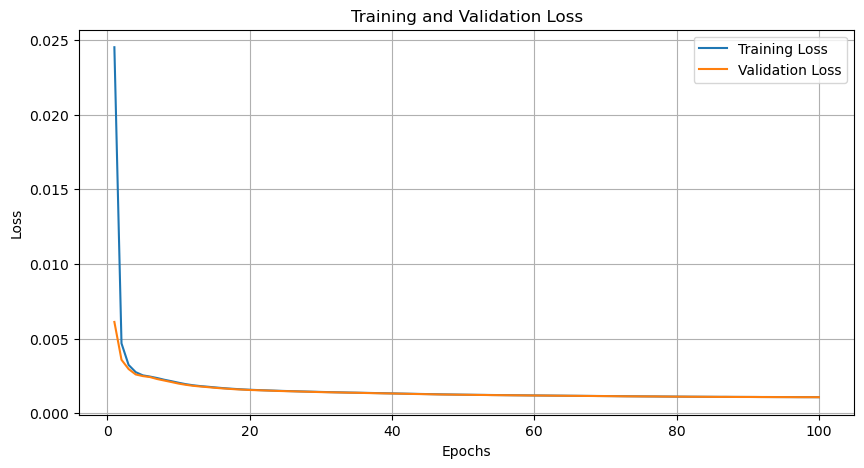

In [26]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


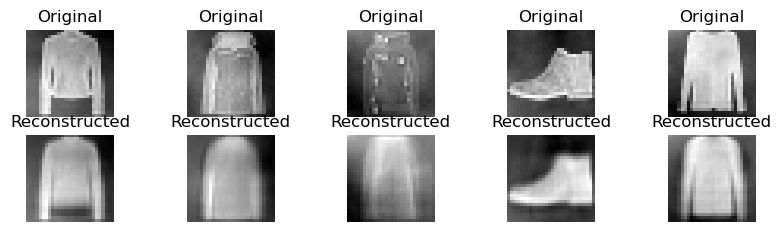

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    test_iter = iter(test_loader)
    images, _ = next(test_iter)
    
    with torch.no_grad():
        images = images.view(images.size(0), -1)  # Flatten images if necessary
        reconstructions = model(images)
        # Reshape reconstructions if necessary
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        images = images.view(-1, 1, 28, 28)  # Reshape back to original for visualization
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(10, 2.5))
    for i in range(num_images):
        # Original images
        ax = axes[0, i]
        ax.imshow(images[i].squeeze().numpy(), cmap='gray')
        ax.set_title('Original')
        ax.axis('off')
        
        # Reconstructed images
        ax = axes[1, i]
        ax.imshow(reconstructions[i].squeeze().numpy(), cmap='gray')
        ax.set_title('Reconstructed')
        ax.axis('off')
    
    plt.show()

# Assuming model is your trained AutoEncoder and test_dataloader is defined
visualize_reconstructions(model, test_dataloader, num_images=5)
